# ARMA-GARCH for Time Series #

Up to now we have assumed that each daily draw from a financial time-series is both independent *and* stationary. This is likely not the case.

There is much debate as to exactly how, but it is more likely that return time series are both correlated to [near-term historical returns](http://finance.martinsewell.com/stylized-facts/dependence/) and trend over various timeframes. Mandelbrot's [MultiFractal Model](references.ipynb) incorporates a form of "long memory", for example.

Here, we will familiarize ourselves with the ARMA models accounting for correlation in the mean and GARCH models accounting for correlation in the volatility. Later on, we will incorporate the Phat distribution into these models.

First, we download the full S&P500 daily time series from YAHOO!.

Then we find both the simple and log returns. There is much debate in finance regarding "simple v log" returns ([see Hudson and Gregoriou (2013)](references.ipynb). Most arguments in favor of log returns tend to [focus on their Gaussian properties](https://quantivity.wordpress.com/2011/02/21/why-log-returns/). Of course, the Gaussian distribution and attempts to squeeze the world into it are anathema to the study of fat tails.

It is common to use log returns in ARMA-GARCH models ([Barigozzi(2014)](references.ipynb)), however, their use does require some limiting statistical properties and can lead to a very different mean/volatility structure.

We will explore the utilization of both going forward. Note the `^GSPC` time series recently reduced to weekly data points for the most the 1940s (why???). So we will start the analysis beginning with 1950.

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns; sns.set(style = 'whitegrid')

In [6]:
import numpy as np
import yfinance as yf

sp = yf.download('^GSPC')
sp_ret = sp.Close.pct_change().loc['1950-01-01':]
sp_lret = np.log1p(sp.Close.pct_change()).loc['1950-01-01':]

[*********************100%***********************]  1 of 1 completed


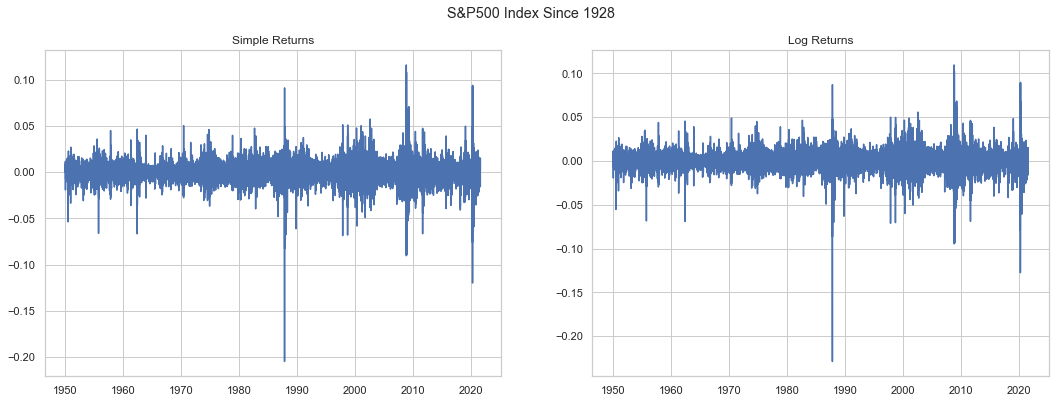

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(sp_ret)
ax2.plot(sp_lret)

ax1.set_title('Simple Returns')
ax2.set_title('Log Returns')

plt.suptitle('S&P500 Index Since 1928')
plt.show()

## Non-Stationarity ##

Stationarity is a key requirement of ARMA models. In time series, non-stationarity is usually evidenced by some trend, [either via drift from the process itself or a deterministic component of time](https://www.investopedia.com/articles/trading/07/stationary.asp).

The augmented Dickey-Fuller test can be used to detect non-stationarity. The null hypothesis is that the time series is *non-stationary*, so if the test statistic is *lower* than the threshold statistic it can be rejected with that significance.

In [8]:
from statsmodels.tsa.stattools import adfuller

adf, p_value, _, _, crit, _ = adfuller(sp.Close, regression='ct')
adf, crit['10%']

(3.9449177286987656, -3.1271819285874165)

Above we see the non-stationary hypothesis cannot be rejected even at just 10% significance-level. Now, we will test for stationarity in the returns.

In [9]:
adf, p_value, _, _, crit, _ = adfuller(sp_lret*100, regression='ct')
adf, crit['1%'], p_value

(-23.41265125334666, -3.959274242553392, 0.0)

In [10]:
adf, p_value, _, _, crit, _ = adfuller(sp_ret*100, regression='ct')
adf, crit['1%'], p_value

(-23.66746259343878, -3.959274242553392, 0.0)

The outcome is the complete opposite. The test statistic is well below the 1% threshold and the p-value is zero. The outcome also seems independent of the `log` return discussion.

Here we see the value in utilizing returns for financial time-series. 

## ARMA ##

There are two approaches to formulating ARMA-GARCH models. One is two-step process that fits the mean process first (ARMA) and then applies GARCH to the residuals. The second fits both the mean and volatility processes simultaneously.

For ARMA-fitting, there are two packages: `statsmodels` and `pmdarima`, with the latter being favored as it has an `auto_arima` function that finds the best model automatically.

For GARCH, the `arch` model is used. `arch` has the ability to AR-GARCH simultaneously, but not any Moving Average (MA) models.

We will demonstrate the two-step process. First, fit the ARMA via `pmdarima` for both simple and log returns.

In [11]:
import pmdarima

sparmasim = pmdarima.auto_arima(sp_ret)
sparmasim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                17991
Model:                        SARIMAX   Log Likelihood               57558.932
Date:                Fri, 23 Jul 2021   AIC                        -115113.863
Time:                        08:35:19   BIC                        -115098.268
Sample:                             0   HQIC                       -115108.735
                              - 17991                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004   7.43e-05      4.828      0.000       0.000       0.001
sigma2      9.742e-05   3.04e-07    320.121      0.000    9.68e-05     9.8e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            338592.48
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                            -0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
sparmalog = pmdarima.auto_arima(sp_lret)
sparmalog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                17991
Model:                        SARIMAX   Log Likelihood               57486.426
Date:                Fri, 23 Jul 2021   AIC                        -114968.851
Time:                        08:35:36   BIC                        -114953.256
Sample:                             0   HQIC                       -114963.723
                              - 17991                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003   7.53e-05      4.112      0.000       0.000       0.000
sigma2      9.821e-05   2.78e-07    353.766      0.000    9.77e-05    9.87e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            545362.24
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                            -1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So, we have a strange result here. Both the simple and the log returns return a constant!

### Importance of Scale ###

We will see here and later on the importance of appropriate scale for ARMA and GARCH fitting. Share price returns have very small differences that impact the weighting of likelihood models. As a result, returns are often scaled by 100 (showing in percentage terms).

```python
sparmasim100 = pmdarima.ARIMA((2,0,2)).fit(sp_ret*100)
```

In [13]:
sparmasim100 = pmdarima.auto_arima(sp_ret*100)
sparmasim100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                17991
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -25283.341
Date:                Fri, 23 Jul 2021   AIC                          50578.682
Time:                        08:36:49   BIC                          50625.468
Sample:                             0   HQIC                         50594.068
                              - 17991                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0135      0.005      2.828      0.005       0.004       0.023
ar.L1          0.0526      0.071      0.745      0.456      -0.086       0.191
ar.L2          0.5717      0.066      8.640      0.000       0.442       0.701
ma.L1         -0.0539      0.069     -0.778      0.437      -0.190       0.082
ma.L2         -0.5977      0.065     -9.179      0.000      -0.725      -0.470
sigma2         0.9731      0.003    306.027      0.000       0.967       0.979
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            336192.52
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.10   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
sparmalog100 = pmdarima.auto_arima(sp_lret*100)
sparmalog100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                17991
Model:               SARIMAX(4, 0, 4)   Log Likelihood              -25337.739
Date:                Fri, 23 Jul 2021   AIC                          50695.478
Time:                        08:41:10   BIC                          50773.454
Sample:                             0   HQIC                         50721.121
                              - 17991                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0167      0.005      3.562      0.000       0.007       0.026
ar.L1         -0.1095      0.058     -1.877      0.061      -0.224       0.005
ar.L2          1.3602      0.063     21.596      0.000       1.237       1.484
ar.L3          0.0045      0.048      0.093      0.926      -0.090       0.098
ar.L4         -0.7819      0.049    -16.119      0.000      -0.877      -0.687
ma.L1          0.1133      0.059      1.926      0.054      -0.002       0.229
ma.L2         -1.3827      0.064    -21.763      0.000      -1.507      -1.258
ma.L3         -0.0079      0.049     -0.161      0.872      -0.104       0.088
ma.L4          0.7854      0.050     15.756      0.000       0.688       0.883
sigma2         0.9790      0.003    323.891      0.000       0.973       0.985
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):            530921.27
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               3.10   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

With the 100x scale we see both datasets converge on an ARMA(2,2) with the simple returns providing a slightly better fit. We examine the model characteristics below.

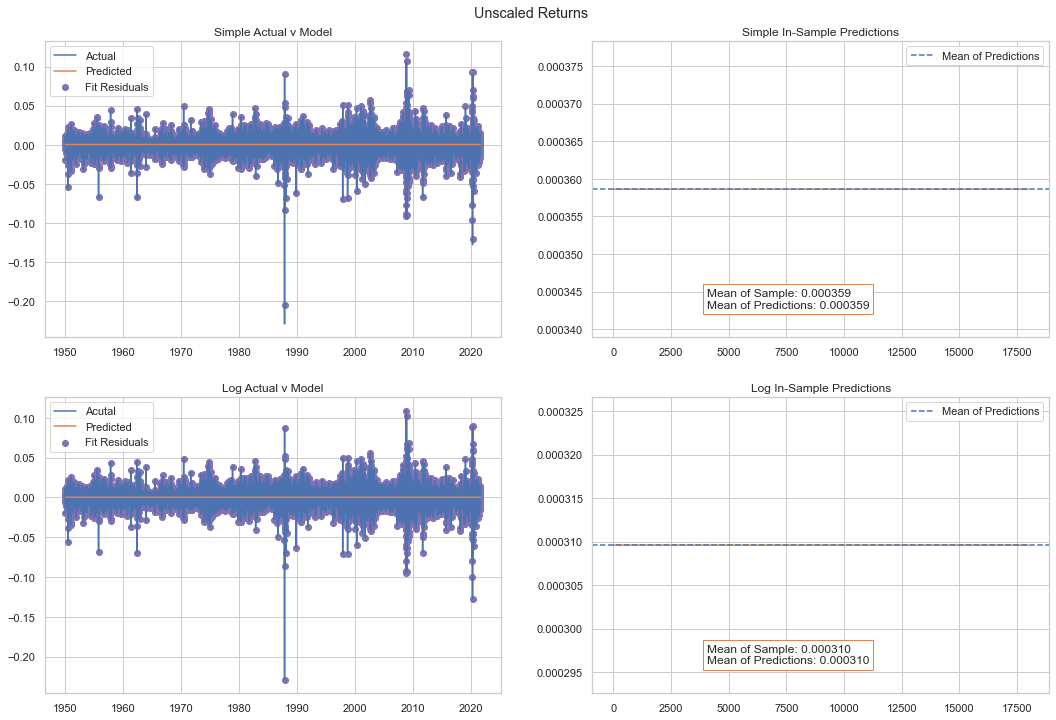

In [16]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(sp_lret, label='Actual')

ax1.scatter(sp_lret.index, sparmasim.resid(), c='C4', label='Fit Residuals')
ax1.plot(sp_lret.index, sparmasim.predict_in_sample(), label='Predicted')
ax1.set_title('Simple Actual v Model')

sim_mean = sparmasim.predict_in_sample().mean()
ax2.plot(sparmasim.predict_in_sample(), c='C1')
ax2.axhline(sim_mean, c='C0', ls='--', label='Mean of Predictions')
ax2.set_title('Simple In-Sample Predictions')

ax2text = f'Mean of Sample: {(sp_ret).mean():.6f}'
ax2text += '\n'
ax2text += f'Mean of Predictions: {sim_mean:.6f}'
ax2.text(
    .25,.1, ax2text, 
    transform=ax2.transAxes, ha='left', 
    bbox=dict(facecolor='white', edgecolor='C1')
)

ax3.plot(sp_lret, label='Acutal')
ax3.scatter(sp_lret.index, sparmalog.resid(), c='C4', label='Fit Residuals')
ax3.plot(sp_lret.index, sparmalog.predict_in_sample(), label='Predicted')
ax3.set_title('Log Actual v Model')

log_mean = sparmalog.predict_in_sample().mean()
ax4.plot(sparmalog.predict_in_sample(), c='C1')
ax4.axhline(log_mean, c='C0', ls='--', label='Mean of Predictions')
ax4.set_title('Log In-Sample Predictions')

ax4text = f'Mean of Sample: {(sp_lret).mean():.6f}'
ax4text += '\n'
ax4text += f'Mean of Predictions: {log_mean:.6f}'
ax4.text(
    .25, .1, ax4text, 
    transform=ax4.transAxes, ha='left', 
    bbox=dict(facecolor='white', edgecolor='C1')
)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.suptitle('Unscaled Returns', y=.92)

plt.show()

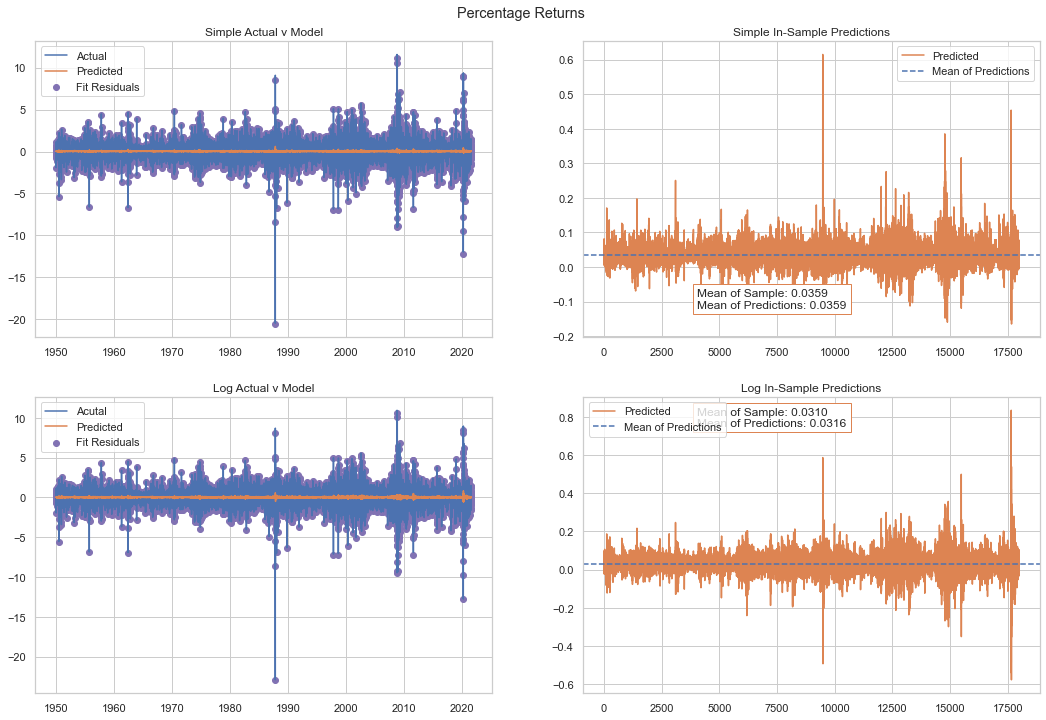

In [17]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(sp_ret*100, label='Actual')
ax1.scatter(sp_ret.index, sparmasim100.resid(), c='C4', label='Fit Residuals')
ax1.plot(sp_ret.index, sparmasim100.predict_in_sample(), label='Predicted')
ax1.set_title('Simple Actual v Model')

sim100_mean = sparmasim100.predict_in_sample().mean()
ax2.plot(sparmasim100.predict_in_sample(), c='C1', label='Predicted')
ax2.axhline(sim100_mean, c='C0', ls='--', label='Mean of Predictions')
ax2.set_title('Simple In-Sample Predictions')

ax2text = f'Mean of Sample: {(sp_ret*100).mean():.4f}'
ax2text += '\n'
ax2text += f'Mean of Predictions: {sim100_mean:.4f}'
ax2.text(
    .25,.1, ax2text, 
    transform=ax2.transAxes, ha='left', 
    bbox=dict(facecolor='white', edgecolor='C1')
)

ax3.plot(sp_lret*100, label='Acutal')
ax3.scatter(sp_lret.index, sparmalog100.resid(), c='C4', label='Fit Residuals')
ax3.plot(sp_lret.index, sparmalog100.predict_in_sample(), label='Predicted')
ax3.set_title('Log Actual v Model')

log100_mean = sparmalog100.predict_in_sample().mean()
ax4.plot(sparmalog100.predict_in_sample(), c='C1', label='Predicted')
ax4.axhline(log100_mean, c='C0', ls='--', label='Mean of Predictions')
ax4.set_title('Log In-Sample Predictions')

ax4text = f'Mean of Sample: {(sp_lret*100).mean():.4f}'
ax4text += '\n'
ax4text += f'Mean of Predictions: {log100_mean:.4f}'
ax4.text(
    .25, .9, ax4text, 
    transform=ax4.transAxes, ha='left', 
    bbox=dict(facecolor='white', edgecolor='C1')
)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.suptitle('Percentage Returns', y=.92)

plt.show()

What we can see from the left-hand charts above is that the ARMA model is generally quite poor at predicting the daily fluctuations in share prices. The residuals are very large and the ARMAs account for only that very thin strip within the actual fluctations.

*However*, on the right-hand charts we can see that the ARMA processes account for *essentially all of the time series mean*.

Also interesting to note the scaled and unscaled models produce similar mean values even though they utilize different processes and have different residuals.

## GARCH Forecasting  ##

So, we have a model describing the stationary and dependent mean process of our time-series. The resulting residuals should have a near-zero, constant mean. 

But we can also see this model is very poor at describing returns. So now we look to incorporate volatility dependence via GARCH. This can be done by fitting a GARCH model to the residuals of the ARMA fit. 

We will focus strictly on scaled simple returns.

In [18]:
import pandas as pd

data = pd.Series(sparmasim100.resid(), index=sp_ret.index)

We use the `arch_model` class from the `arch` package, which defaults to GARCH(1,1).

In [19]:
import arch

model = arch.arch_model(data, p=1, q=1)
model_fit = model.fit(disp='off')
model_fit.params.mu, sparmasim100.resid().mean()

(0.020040473180381154, -2.704853466740512e-05)

The prodcues an interesting value in the mean. We expected a near-zero mean and ended up with a ~0.02%. Still relatively small, but noticeably larger than the ARMA fit. By incorporating conditional volatility, we have essentially revealed a larger mean process within the residuals (or picked up an artifact therein).

The `model_fit` object can be used to forecast future residual values.

In [20]:
pred = model_fit.forecast(horizon=100, simulations=1, method='simulation', reindex=False)

We can see a single 100-day forecast below, resulting from the small, positive mean and the dynamic variance.

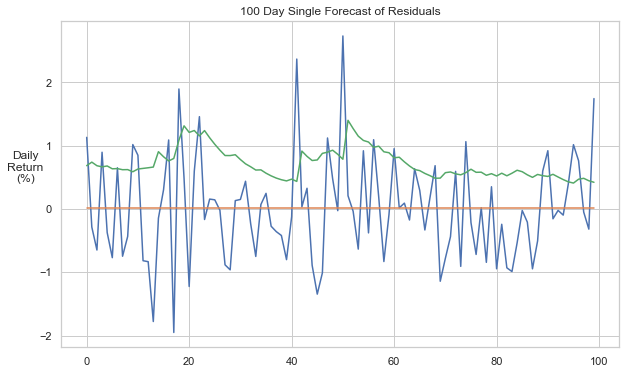

In [21]:
plt.figure(figsize=(10,6))
plt.plot(pred.simulations.values[0,0], label='Forecast Values')
plt.plot(pred.mean.iloc[0].values, label='Mean')
plt.plot(pred.variance.iloc[0].values, label='Variance')


plt.ylabel('Daily\nReturn\n(%)', loc='center', rotation='horizontal', labelpad=14)
plt.title('100 Day Single Forecast of Residuals')

plt.show()

We can show how a forecast compares with actual data, by fitting against a past subset and projecting forward from the last fitted date.

In [22]:
model = arch.arch_model(data[:-100], p=1, q=1)
model_fit = model.fit(disp='off')

GARCH models incorporate a stochastic error term generated from standard Gaussian white noise, so the value of any single simulation is minimal. Below we show the deviation of four forecasts relative to the actual.

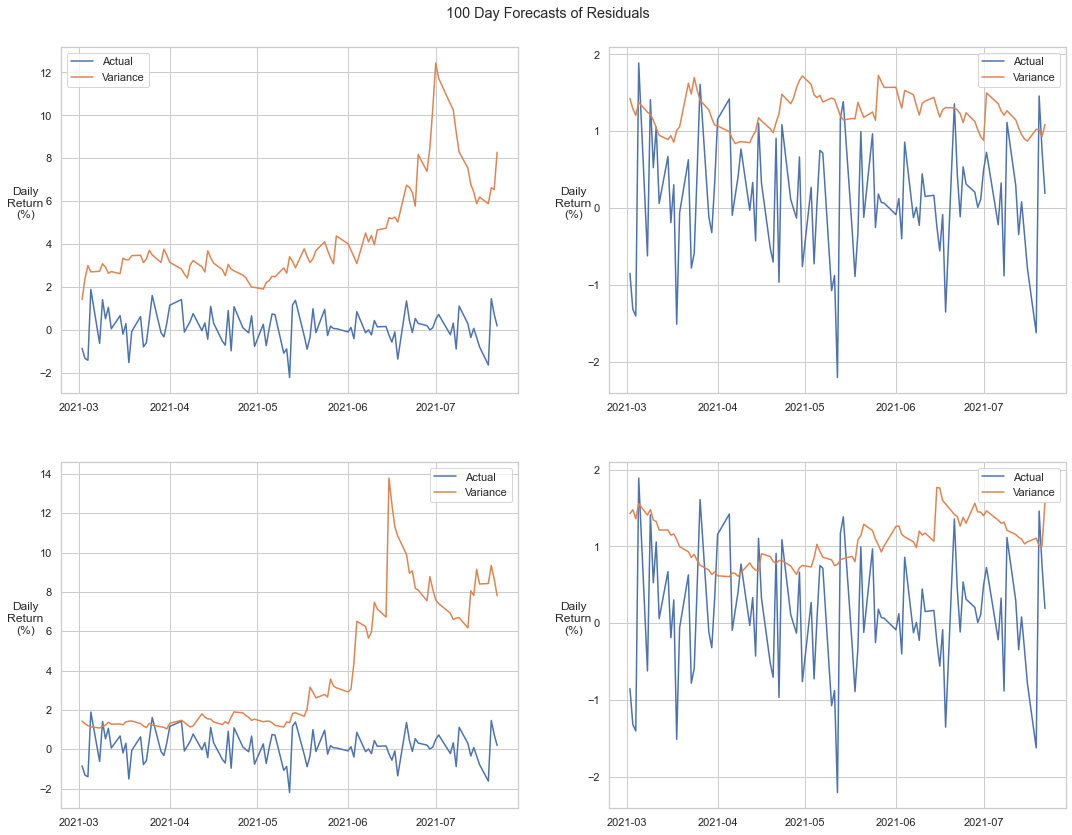

In [23]:
fig, axs = plt.subplots(2,2,figsize=(18,14))

for ax in axs.flatten():
    pred = model_fit.forecast(horizon=100, simulations=1, method='simulation', reindex=False)
    ax.plot(data[-100:], label='Actual')
    ax.plot(data[-100:].index, pred.variance.iloc[0].values, label='Variance')
    ax.set_ylabel('Daily\nReturn\n(%)', loc='center', rotation='horizontal', labelpad=14)
    ax.legend()
    
plt.suptitle('100 Day Forecasts of Residuals', y=.92)

plt.show()

### Projection w Expanding Window ###

We can arrive at a better fit to the data if we use a window-process. Time-series models can be fit either over the entire time-series or over a window. The intent is to capture any changes in the parameters of the series over time.

An expanding window approach fits the model on an ever-increasing window over a chosen increment. Below we show an expanding window incremented daily.

In [24]:
from tqdm.auto import trange, tqdm

n = 100
vars_ = np.zeros(n)
means_ = np.zeros(n)
for i in trange(n):
    train = data[:-(n-i)]
    model = arch.arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=False)
    means_[i] = pred.mean.values[-1][0]
    vars_[i] = np.sqrt(pred.variance.values[-1,:][0])

  0%|          | 0/100 [00:00<?, ?it/s]

We can see below that the forecast variance fits very nicely with the actual. One should also note that the mean value changes slighlty over the 100-day forecast.

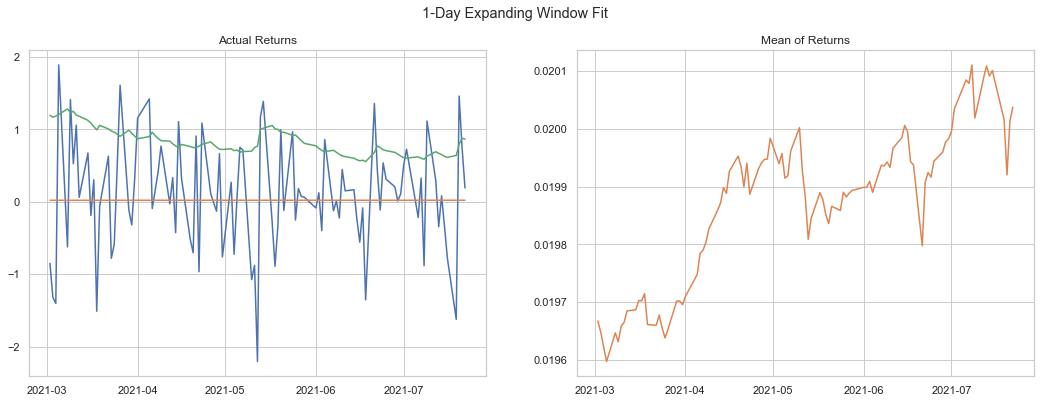

In [26]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(data[-n:])
ax1.plot(data.index[-n:], means_)
ax1.plot(data.index[-n:], vars_)

ax2.plot(data.index[-n:], means_, c='C1')

ax1.set_title('Actual Returns')
ax2.set_title('Mean of Returns')

plt.suptitle('1-Day Expanding Window Fit')

plt.show()

We can see this is especially true over a longer time period. Here we increase to 5,000 days.

In [67]:
n = 5000
vars_ = np.zeros(n)
means_ = np.zeros(n)
for i in trange(n):
    train = data[:-(n-i)]
    model = arch.arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=False)
    means_[i] = pred.mean.values[-1][0]
    vars_[i] = np.sqrt(pred.variance.values[-1,:][0])

 64%|█████████████████████            | 3187/5000 [04:47<03:02,  9.91it/s]/Users/spindicate/.pyenv/versions/3.9.0/envs/phatpack/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
 93%|██████████████████████████████▋  | 4643/5000 [07:23<00:38,  9.19it/s]/Users/spindicate/.pyenv/versions/3.9.0/envs/phatpack/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|█████████████████████████████████| 5000/5000 [08:02<00:00, 10.37it/s]


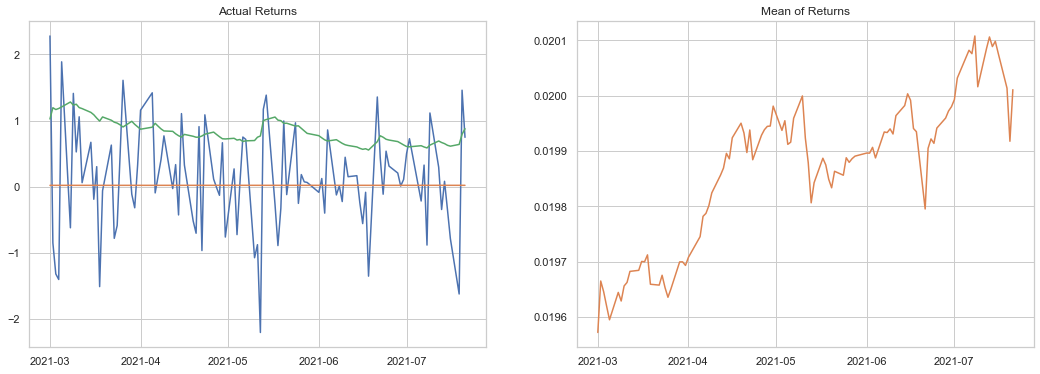

In [170]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(data[-n:])
ax1.plot(data.index[-n:], means_)
ax1.plot(data.index[-n:], vars_)

ax2.plot(data.index[-n:], means_, c='C1')

ax1.set_title('Actual Returns')
ax2.set_title('Mean of Returns')

plt.suptitle('1-Day Expanding Window Fit')

plt.show()

We can see the variance captures the spikes in daily changes very nicely.

### Feed Forward for Out-of-Sample Projections ###

Instead of using a multi-horizon forecast via the `forecast` method of `arch`, the forecast can be created by refitting a new model that incorporates the most recent forecast. We will show this process on just the last 20 years of data.

In [27]:
n = 252
window = 5040
foredata = data[-window:].copy()
foredata = np.concatenate((foredata, np.zeros(n)*np.nan))

In [28]:
values = np.zeros(n)
for i in trange(n):
    train = foredata[:-n+i]
    model = arch.arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, simulations=1, method='simulation', reindex=False)
    values[i] = pred.simulations.values[0,0,0]
    foredata[-n+i] = values[i]

  0%|          | 0/252 [00:00<?, ?it/s]

Below we can see the go-forward projection that results. Not a bad result, but it does seem like some of the more extreme values are not replicated.

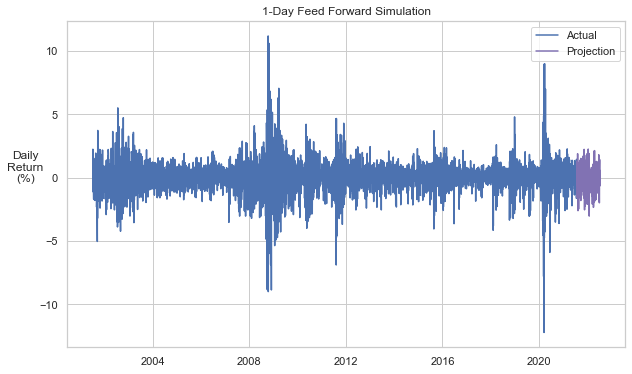

In [29]:
start = data.size - window
x_hist = np.arange(start, start + window)
x_proj = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n, freq='B')

plt.figure(figsize=(10,6))
plt.plot(data.iloc[start:], label='Actual')
plt.plot(x_proj, foredata[-n:], c='C4', label='Projection')
plt.ylabel('Daily\nReturn\n(%)', loc='center', rotation='horizontal', labelpad=14)
    
plt.legend()
plt.title('1-Day Feed Forward Simulation')

plt.show()

### Fixed Windows  ###

Instead of an expanding window, a fixed window can be rolled forward. The observations may or may not overlap. This approach more directly captures state changes in the model that may occur over time, although it does also clip information.

First, we show a fixed window on recent data (same as above) incremented forward daily for the last 252 days. This will utilize the same feed-forward forecast used above.

In [30]:
import scipy.stats as scist

n = 252
window = 5040
foredata = data[-window:].copy()
foredata = np.concatenate((foredata, np.zeros(n)*np.nan))

In [31]:
vars_ = np.zeros(n)
means_ = np.zeros(n)
errs_ = np.zeros(n)
for i in trange(n):
    model = arch.arch_model(foredata[i:-n+i], p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=False)
    means_[i] = pred.mean.values[-1][0]
    vars_[i] = np.sqrt(pred.variance.values[-1,:][0])
    errs_[i] = np.sqrt(vars_[i])*scist.norm.rvs()
    foredata[window + i] = means_[i] + errs_[i]

  0%|          | 0/252 [00:00<?, ?it/s]

The result is below. Here we see perhaps a bit more variation. This may result from less smoothing through the smaller sample, different properties of the specific window, or it may be from the random error term.

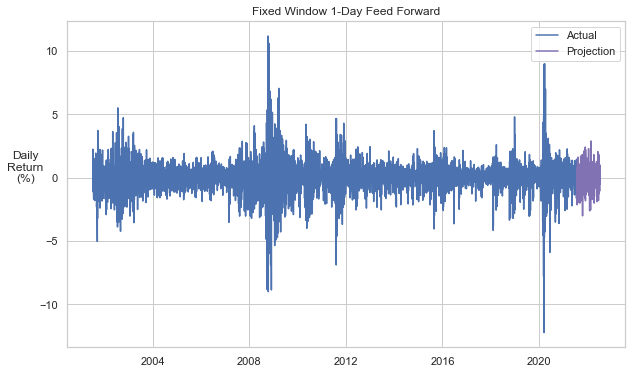

In [32]:
start = data.size - window
x_hist = np.arange(start, start + window)
x_proj = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n, freq='B')

plt.figure(figsize=(10,6))
plt.plot(data.iloc[start:], label='Actual')
plt.plot(x_proj, foredata[-n:], c='C4', label='Projection')

plt.ylabel('Daily\nReturn\n(%)', loc='center', rotation='horizontal', labelpad=14)
    
plt.legend()
plt.title('Fixed Window 1-Day Feed Forward')

plt.show()

### Fixed Window Across Entire Time Series ###

We will expand the above to fit a fixed window across the entire time series. There will be 13 windows. We will drop two years of data with each shift in the window. This results in a window of ~13 years.

In [33]:
n_windows = 13
drop = 252*5
window = data.size - n_windows*drop

windex = np.array([np.arange(drop*i+1, drop*i + window) for i in range(n_windows + 1)])

In [34]:
vars_ = np.zeros((n_windows+1, window-1))
resids = np.zeros_like(vars_)
for i in trange(n_windows + 1):
    model = arch.arch_model(data[windex[i]], p=1, q=1)
    model_fit = model.fit(disp='off')
    resids[i] = model_fit.std_resid

  0%|          | 0/14 [00:00<?, ?it/s]

Below we show how the conditional volatility fit and the remaining residuals for each observation.

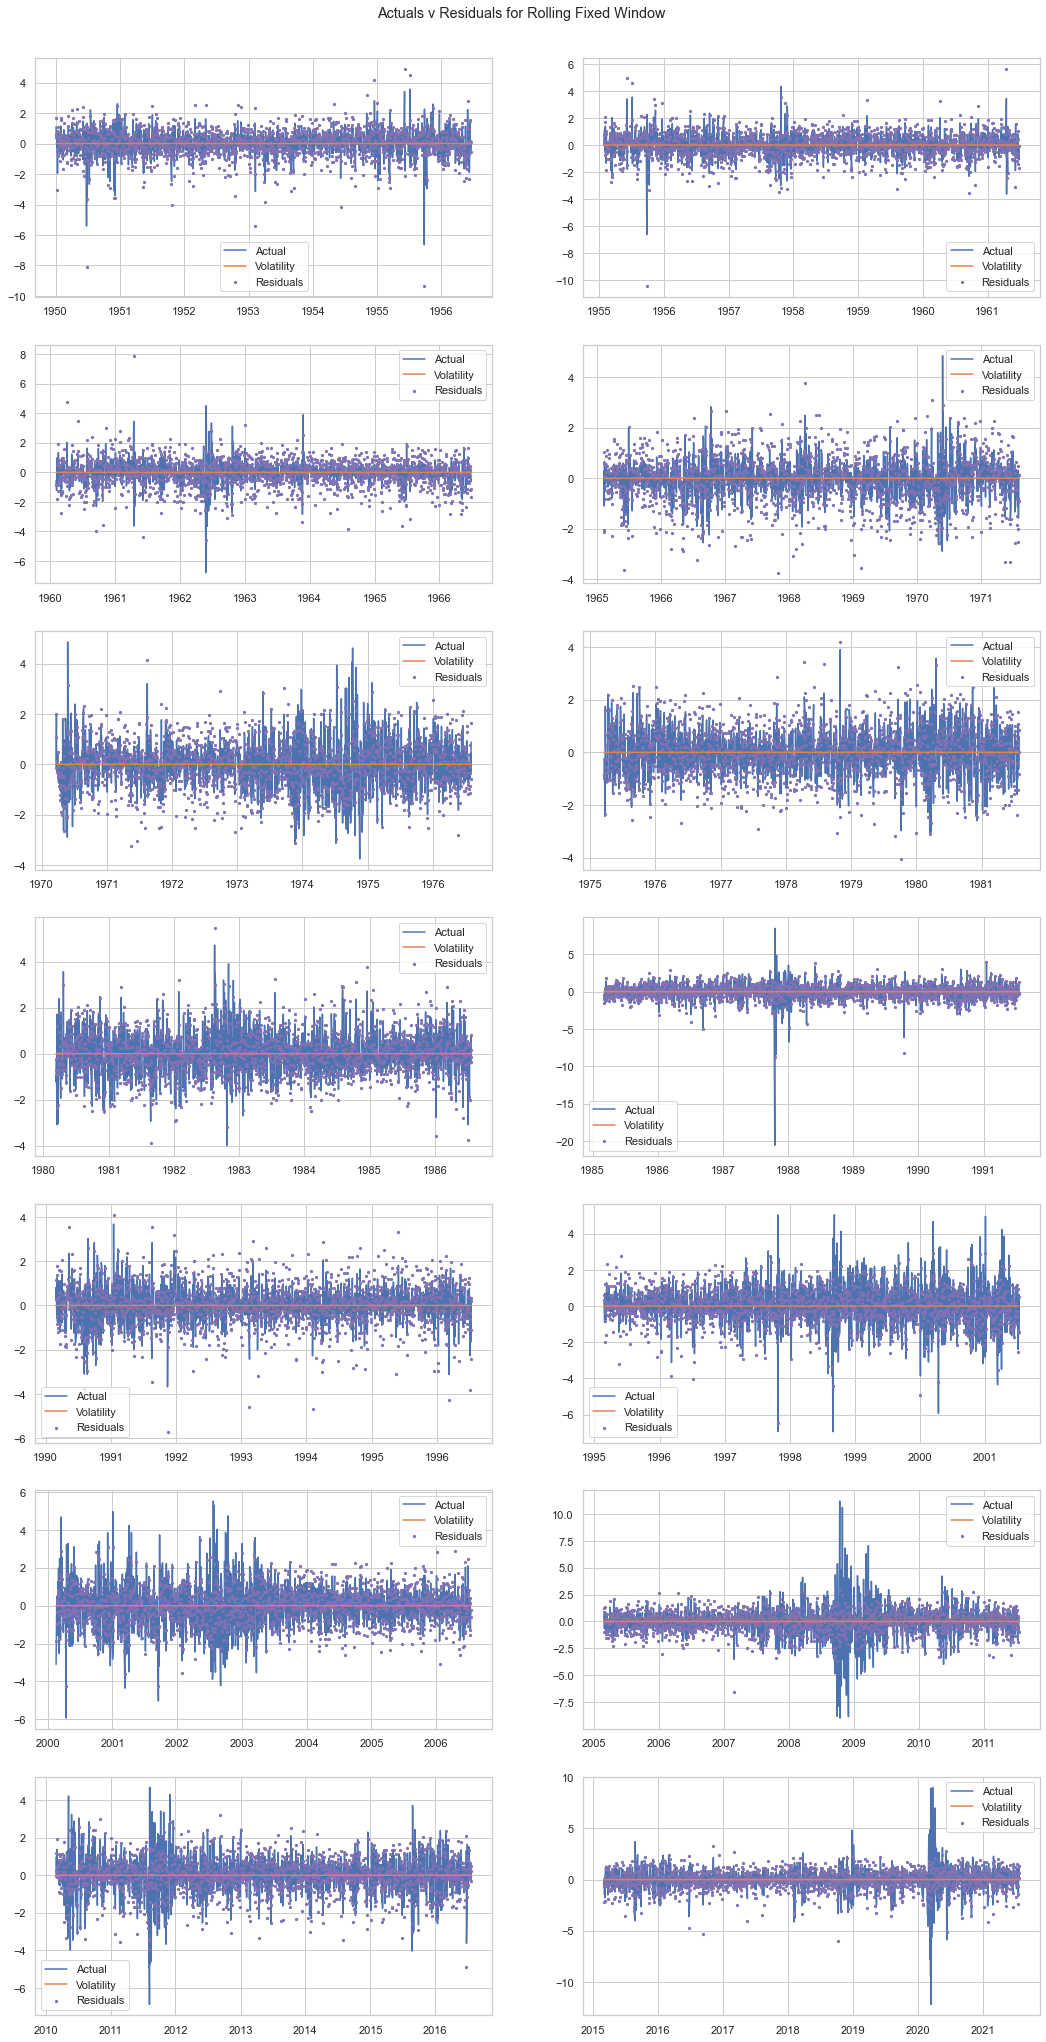

In [35]:
fig, axs = plt.subplots(7,2,figsize=(18,6*6))
axs = axs.flatten()
for i in range(n_windows+1):
    axs[i].plot(data[windex[i]], label='Actual')
    axs[i].plot(data[windex[i]].index, vars_[i], zorder=3, label='Volatility')    
    axs[i].scatter(data[windex[i]].index, resids[i], c='C4', zorder=3, s=5, label='Residuals')
    
    axs[i].legend()
    
plt.suptitle('Actuals v Residuals for Rolling Fixed Window', y=.9)
plt.show()

## Integrated ARMA-GARCH Forecasts with Garchcaster ##

Forecasting the residuals is helpful but doesn't get us to a full price simulation. To do that, we have to also incorporate the mean process in the ARMA model. In ARMA-GARCH both the mean and variance in the current period are functions of the residual in the prior period. So *both* the ARMA and GARCH must be produced in conjunction at each step in the forecast.

The full ARMA-GARCH system looks as follows:

$$
y_t = \mu_t + \epsilon_t
\\\mu_t = \phi_0 + \sum\limits_{i=1}^m\phi_iy_{t-i} + \sum\limits_{j=1}^n\theta_j\epsilon_{t-j} + \epsilon_t
$$
$$
\\\epsilon_t = e_t\sigma_t
$$
$$
\\\sigma_t^2 = \alpha_0 + \sum\limits_{l=1}^p\beta_l\sigma_{t-l}^2 + \sum\limits_{k=1}^q\alpha_k\epsilon_{t-k}^2
$$

*Note this does not exhaust the bevy of GARCH extensions: HARCH, FIGARCH, GJR-GARCH, etc.*

The `arch` package has a `forecast` method built-in to its results object, however, we developed our own forecasting class to allow for some greater flexibility. See `Garchcaster` under the `garch` module. The class uses **Numba** to speed up processing time.

We will simulate 252 days of price movement 10,000 times.

In [36]:
import phat as ph

days = 252
sims = 10000
mod = ph.Garchcaster(
    data.values.copy(), 
    model_fit.conditional_volatility.values.copy(),
    model_fit.resid.values.copy(),
    sparmasim100.params()[:5],
    model_fit.params.values,
    iters=sims,
    periods=days,
)
rets = mod.forecast()

The `GarchcastResults` container has a number of chart devices available to inspect the data, including converting the daily returns into price. Below we show four sample iterations of the 252 day forecast, assuming the starting price of the asset was $100.

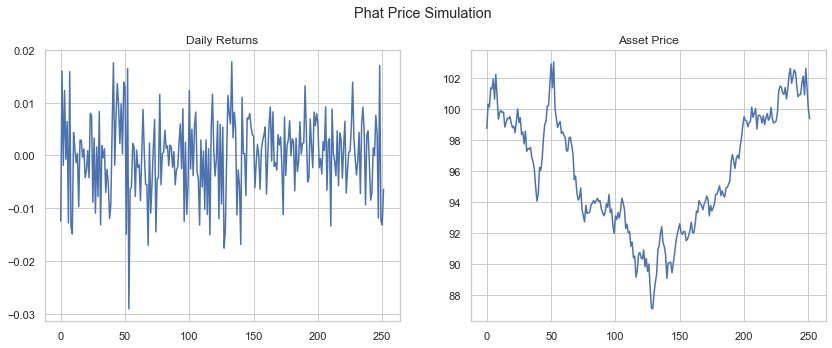

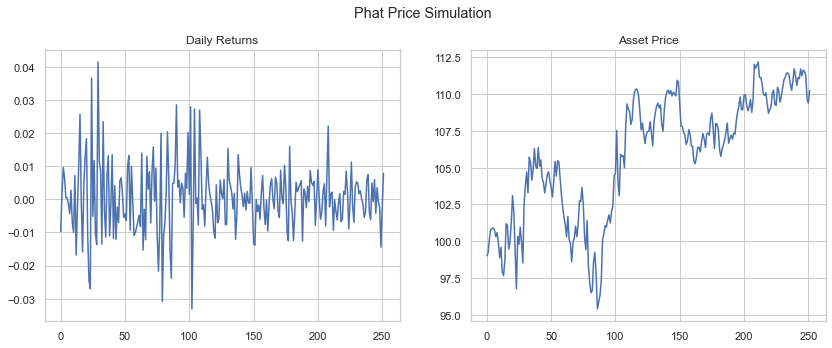

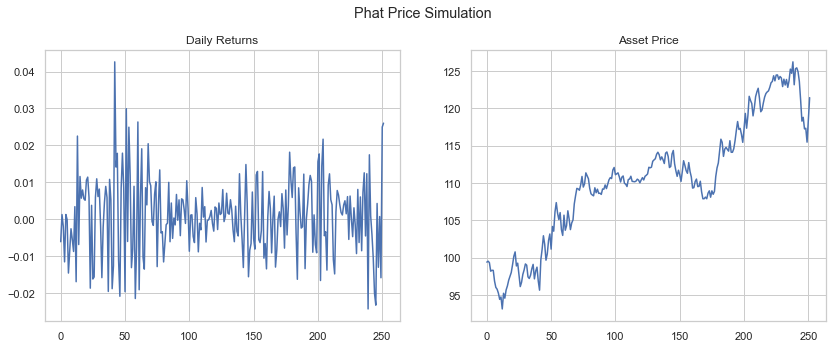

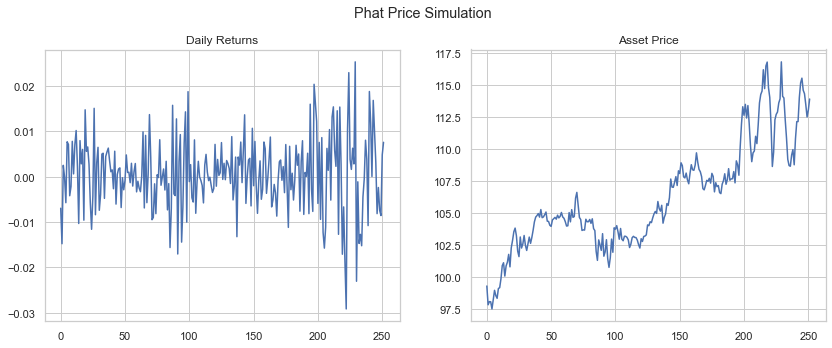

In [37]:
rets.plot('price', p=100, n=4)
plt.show()

We can show the distribution of prices on the final day of the forecast as well, while adding additional analysis on top.

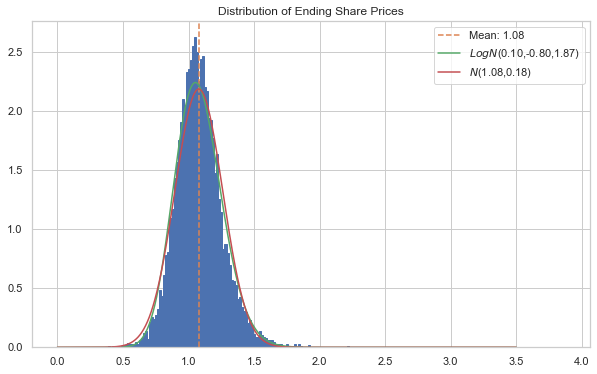

In [39]:
ax, S, bins = rets.plot('end_price', p=1)
plt.rcParams['patch.edgecolor'] = 'C0'

ax.axvline(S[:, -1].mean(), c='C1', ls='--', label=f'Mean: {S[:, -1].mean():.2f}')

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(0, 3.50, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ps = scist.norm.fit(S[:, -1])
normfit = scist.norm.pdf(x, *ps)
ax.plot(x, normfit, c='C3', label=r'$N$'+f'({ps[0]:.2f},{ps[1]:.2f})')

ax.legend()
plt.show()

We can see the lognormal is perhaps a slightly better fit than the normal for the 252 day price distribution. This is to be expected given the fit via standard normal residuals.

The tail values are difficult to see. We can examine those better by comparing quantiles.

In [40]:
l_crit = 1/np.logspace(2,5,4)
r_crit = 1 - l_crit
qs = np.concatenate((l_crit[::-1], r_crit))
logqs = scist.lognorm(*logps).ppf(qs)

actual = np.quantile(S[:,-1], qs)
pd.DataFrame(list(zip(logqs, actual)), index=qs, columns=['Lognorm', 'ARMA-GARCH'])

,Lognorm,ARMA-GARCH
0.00001,0.444236,0.126895
0.00010,0.510789,0.148299
0.00100,0.591887,0.492185
0.01000,0.697208,0.675191
0.99000,1.535274,1.585041
0.99900,1.712167,1.973063
0.99990,1.867801,2.810977
0.99999,2.010722,3.764279


Interestingly, the GARCH exhibits some modest fat-tailed behavior. This property has been understood since the very first GARCH paper by [Bollerslev (1986)](references.ipynb).

### Garchcaster Tests ###

As a check of the validity of the forecasts, we can compare to the same parameter setup from the `arch` `forecast` method. We'll assume a constant mean process derived straight from the GARCH fit from `arch`.

First, we'll show how the average variance at each day of the forecast compares by looking at small samples. We will do just 20 samples, repeated 6 times.

In [41]:
days = 252
sims = 20
mod = ph.Garchcaster(
    data.values.copy(), 
    model_fit.conditional_volatility.values.copy(),
    model_fit.resid.values.copy(),
    None,
    model_fit.params.values,
    iters=sims,
    periods=days,
)

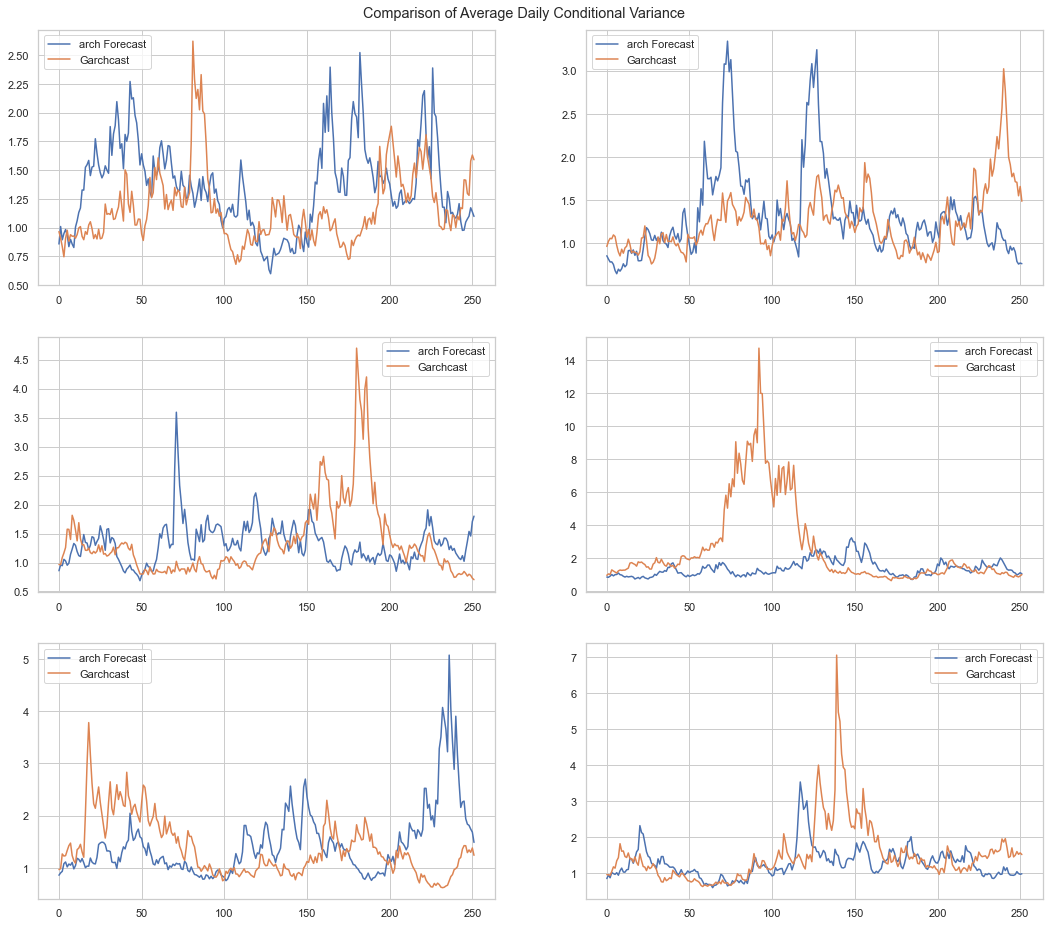

In [42]:
fig, axs = plt.subplots(3,2,figsize=(18,16))

for ax in axs.flatten():
    rets = mod.forecast()
    archsim = model_fit.forecast(horizon=days, simulations=sims, method='simulation', reindex=False)

    ax.plot(archsim.variance.values.T, label='arch Forecast')
    ax.plot((rets.vols**2).mean(axis=0), label='Garchcast')
    ax.legend()

plt.suptitle('Comparison of Average Daily Conditional Variance', y=.9)
plt.show()

The two methods appear to create similar volatility behavior. If we increase to `sims=10000`, we can see that the methods tend towards the same stable value over time. Again, the charts below show the *average* variance for 10,000 simulations over two separate time periods: 252 days and 504 days.

In [43]:
days = 252
sims = 10000
mod = ph.Garchcaster(
    data.values.copy(), 
    model_fit.conditional_volatility.values.copy(),
    model_fit.resid.values.copy(),
    None,
    model_fit.params.values,
    iters=sims,
    periods=days,
)

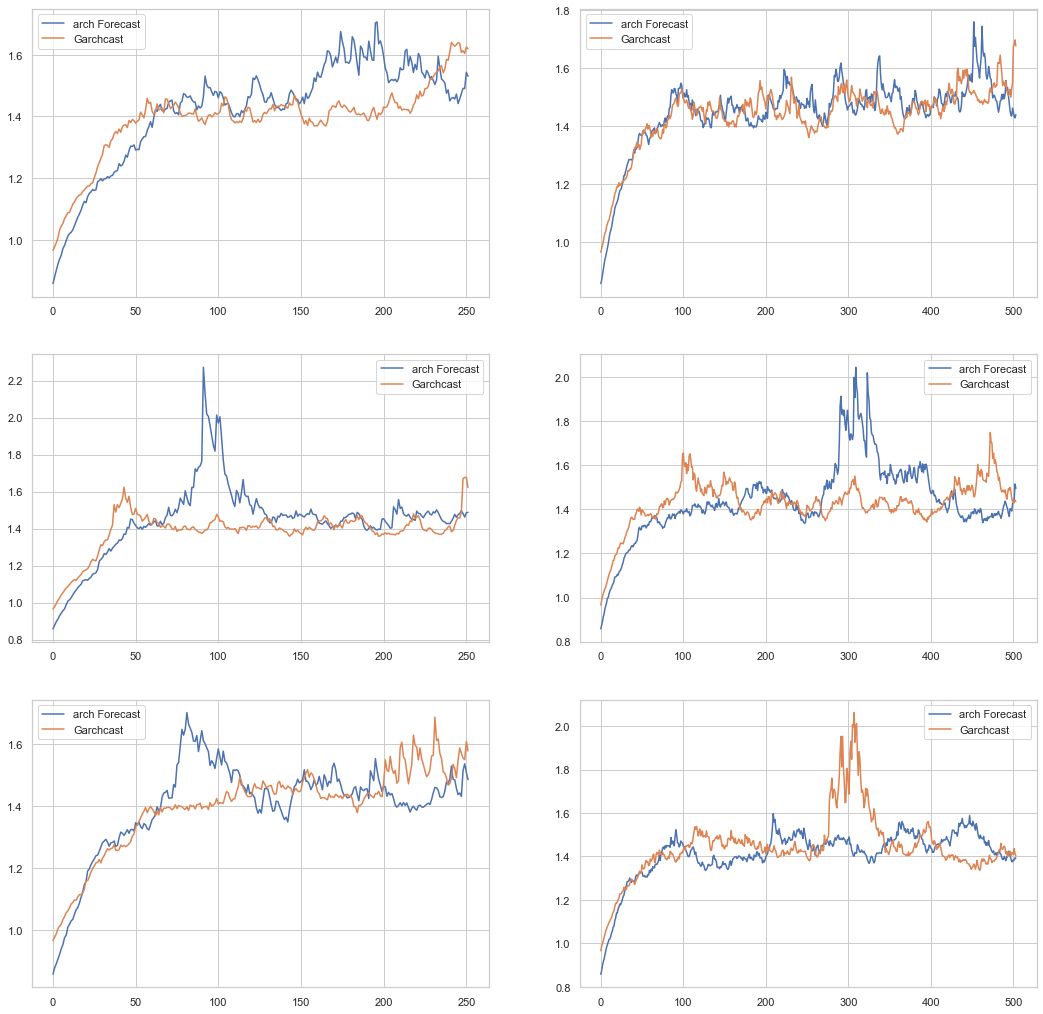

In [44]:
fig, axs = plt.subplots(3,2,figsize=(18,18))

for row in axs:
    for ax, days in zip(row,[252, 504]):
        rets = mod.forecast(periods=days)
        archsim = model_fit.forecast(horizon=days, simulations=sims, method='simulation', reindex=False)    
        ax.plot(archsim.variance.values.T, label='arch Forecast')
        ax.plot((rets.vols**2).mean(axis=0), label='Garchcast')
        ax.legend()
    
plt.show()

Below we can see over 10,000 iterations the last period price ranges are almost identical for both methods

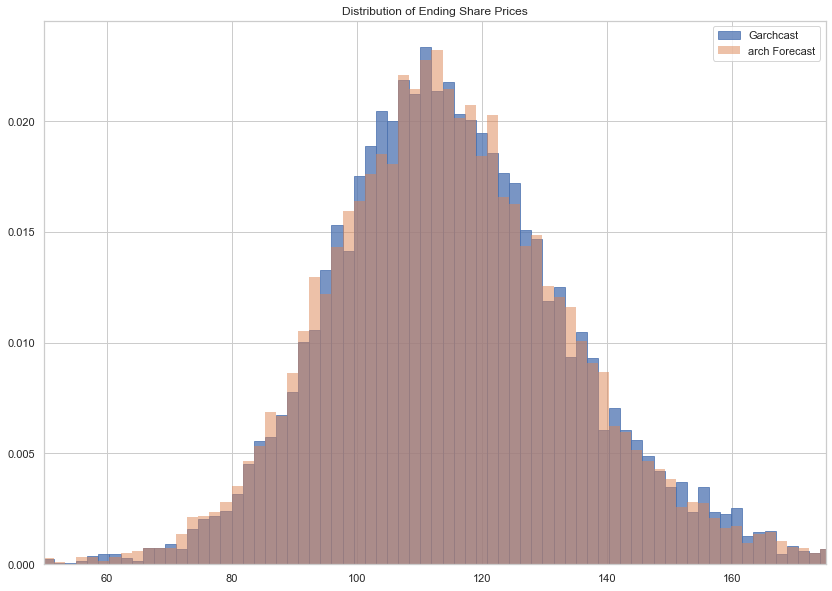

In [45]:
from phat.utils import PriceSim

fig, ax = plt.subplots(1,1, figsize=(14,10))

rets = mod.forecast(periods=252)
archsim = model_fit.forecast(horizon=252, simulations=sims, method='simulation', reindex=False)    
ax, S, bins = rets.plot('end_price', p=100, ax=ax, label='Garchcast', alpha=.75)

simmer = PriceSim(100, periods=252, n=sims)
archsims_rets, archS, (ax, _) = simmer.sims(
    rets=archsim.simulations.values[0]/100+1,
    show_chart=True, 
    ax=ax, 
    bins=bins, lw=0, alpha=.5, label='arch Forecast'
)

ax.set_xlim(50, 175)

ax.legend()
plt.show()

We do a speed comparison below as well:

In [301]:
%timeit rets = mod.forecast(periods=252)

1.51 s ± 60.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [302]:
%timeit archsim = model_fit.forecast(horizon=252, simulations=sims, method='simulation', reindex=False)

468 ms ± 7.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see the custom forecast in `phat-tails` is about half as fast. Not great but also not bad given no parallelization and no other attempt to optimize has yet been employed.